## Background

### 1. Brief explanation on the architechtures of autoencoder

<img src="image/autoencoder.png" width="50%">

#### 1.1. Encoder
The encoder is a set of neural networks that compress the input data into a compact section called the bottleneck.

#### 1.2 Bottleneck
The bottleneck is the core of the neurak networks where it is the compressed knowledge-representation of the input.

#### 1.3. Decoder
The decoder is used to upsample and reconstructs the output of bottleneck.

### 2. Key hyper-parameters in training an autoencoder

#### 2.1. Code Size

- The code size determines the size of the bottleneck.
- It is used as the input size of the last layer in encoder.

#### 2.2. Loss Function

- The loss function is highly dependent on the data type.
- For example, MSE and L1 Loss are popular when the input and output are images.
- Binary cross entroppy loss can be used when the inputs and outputs are within the range [0,1]

#### 2.3. Number of Layers and  Number of Nodes per Layer

- Similar to other nueral networks, these are the important hyper-parameters that could affect the performance of autoencoder greatly.

### 3. Main advantage of autoencoder

Autoencoder is an unsupervised neural networks where it does not need labels for training. From the experiment below, the performance of autoencoder is comparable to LGBM model although autoencoder is being trained without the train labels. Hence, it serves as a very good alternatives if we do not have labels on hand.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix

import lightgbm as lgb

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [2]:
DATA_PATH = 'dataset/ecg.csv'
data = pd.read_csv(DATA_PATH, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [33]:
pd.value_counts(data[140])

1.0    2919
0.0    2079
Name: 140, dtype: int64

## **EDA**

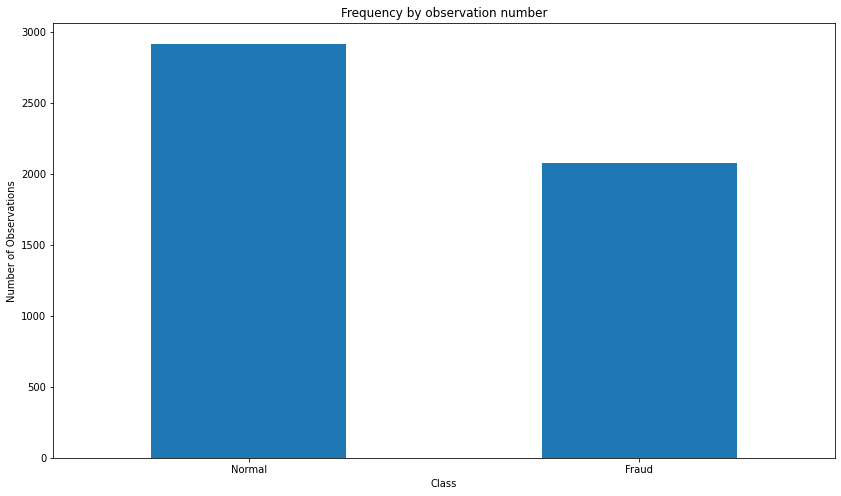

In [34]:
LABELS = ["Normal","Fraud"]
count_classes = pd.value_counts(data[140], sort = True)
count_classes.plot(kind = 'bar', rot=0, figsize=(14, 8))
plt.xticks(range(2), LABELS)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

## **Train Test Split**

In [35]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET_COL = 140

features = data.drop(TARGET_COL, axis=1)
target = data[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, stratify=target
)

## **Baseline Result**

**Cross validation in LGBM**

In [36]:
NUM_FOLDS = 5
RANDOM_STATE = 0

lgbm_model = lgb.LGBMClassifier(boosting_type='goss')
lgbm_pipeline = make_pipeline(MinMaxScaler(feature_range=(0, 1)), lgbm_model)

kf = KFold(n_splits=NUM_FOLDS, random_state=RANDOM_STATE, shuffle=True)

scores = cross_val_score(estimator=lgbm_pipeline, X=X_train, y=y_train, cv=kf, scoring="f1", n_jobs=-1)
print(scores)
print(scores.mean())

[0.99022005 0.9939976  0.99408284 0.99012346 0.99491094]
0.9926669772884017


In [37]:
# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = min_max_scaler.fit_transform(X_train.copy())
X_test_scaled = min_max_scaler.transform(X_test.copy())

In [38]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(3498, 140)
(1500, 140)


In [39]:
lgbm_model = lgb.LGBMClassifier(boosting_type='goss')
lgbm_model.fit(X=X_train_scaled, y=y_train)
lgbm_preds = lgbm_model.predict(X_test_scaled)

0.9920091324200914


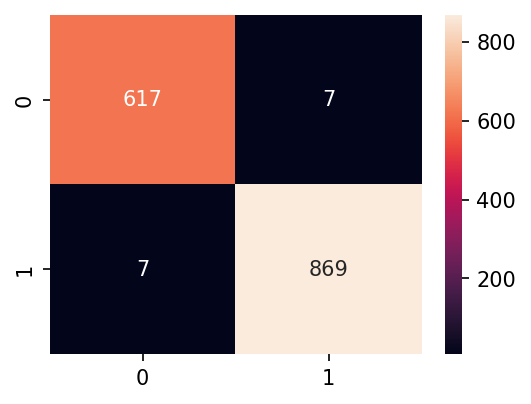

In [40]:
# Show summary of performance
print(f1_score(lgbm_preds, y_test))
cf_matrix = confusion_matrix(y_test, lgbm_preds)

plt.figure(dpi=150, figsize=(4, 3))
sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

## AutoEncoder

In [41]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
    """
    Parameters
    ----------
    output_units: int
    Number of output units

    code_size: int
    Number of units in bottle neck
    """

    def __init__(self, output_units, code_size=8):
        super().__init__()

        self.encoder = Sequential([
          Dense(64, activation='relu'),
          Dropout(0.1),
          Dense(32, activation='relu'),
          Dropout(0.1),
          Dense(16, activation='relu'),
          Dropout(0.1),
          Dense(code_size, activation='relu')
        ])

        self.decoder = Sequential([
          Dense(16, activation='relu'),
          Dropout(0.1),
          Dense(32, activation='relu'),
          Dropout(0.1),
          Dense(64, activation='relu'),
          Dropout(0.1),
          Dense(output_units, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

def create_model(output_size):

    model = AutoEncoder(output_units=output_size)
    # configurations of model
    model.compile(loss="msle", metrics=['mse'], optimizer='adam')

    return model

def find_threshold(model, X_valid):
    
    reconstructions = model.predict(X_valid)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.msle(reconstructions, X_valid)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())

    return threshold

def get_predictions(model, X_test_scaled, threshold):
    
    predictions = model.predict(X_test_scaled)
    # provides losses of individual instances
    errors = tf.keras.losses.msle(predictions, X_test_scaled)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    
    return preds

In [42]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = X_train.loc[train_index]

------------------------------------------------------------------------
Training for fold 1 ...


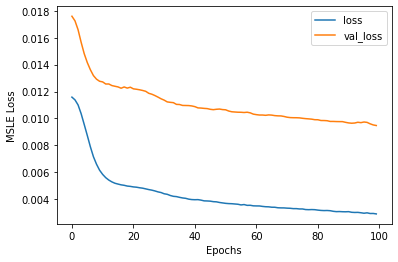

Threshold in 1: 0.015300118966479474
------------------------------------------------------------------------
Training for fold 2 ...


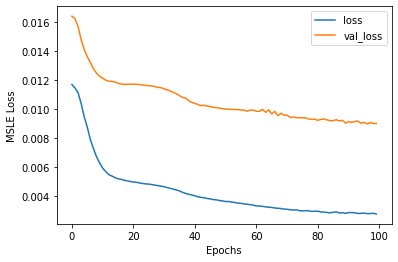

Threshold in 2: 0.013582586838041102
------------------------------------------------------------------------
Training for fold 3 ...


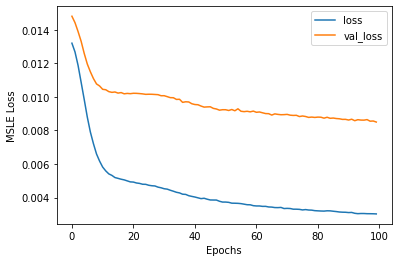

Threshold in 3: 0.014777977973547664
------------------------------------------------------------------------
Training for fold 4 ...


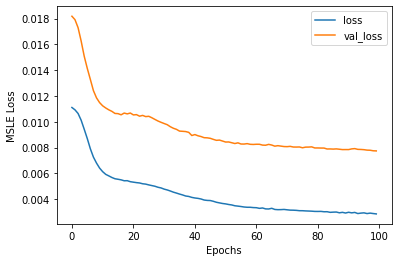

Threshold in 4: 0.011910105380188801
------------------------------------------------------------------------
Training for fold 5 ...


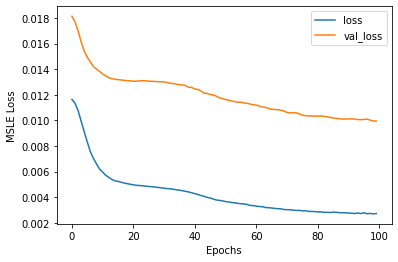

Threshold in 5: 0.015114266545264949


In [43]:
NUM_FOLDS = 5
RANDOM_STATE = 0

thresholds = list()
output_size = train_data.shape[1]
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Define the K-fold Cross Validator
kf = KFold(n_splits=NUM_FOLDS, random_state=RANDOM_STATE, shuffle=True)

# K-fold Cross Validation model evaluation
for fold_no, (train, valid) in enumerate(kf.split(train_data)):

    # min max scale the input data
    X_train_scaled = min_max_scaler.fit_transform(train_data.iloc[train])
    X_valid_scaled = min_max_scaler.fit_transform(train_data.iloc[valid])

    model = create_model(output_size)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no+1} ...')

    # Fit data to model  
    history = model.fit(X_train_scaled,
                      X_train_scaled,
                      epochs=100,
                      batch_size=512,
                      verbose=0,
                      validation_data=(X_valid_scaled, X_valid_scaled))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('MSLE Loss')
    plt.legend(['loss', 'val_loss'])
    plt.show()

    threshold = find_threshold(model, X_valid_scaled)
    thresholds.append(threshold)
    print(f'Threshold in {fold_no+1}: {threshold}')


In [44]:
print(thresholds)
mean_threshold = sum(thresholds)/len(thresholds)
print(mean_threshold)

[0.015300118966479474, 0.013582586838041102, 0.014777977973547664, 0.011910105380188801, 0.015114266545264949]
0.014137011140704397


In [45]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = X_train.loc[train_index]

# min max scale the input data
X_train_scaled = min_max_scaler.fit_transform(train_data.copy())
X_test_scaled = min_max_scaler.transform(X_test.copy())

0.947888096544158


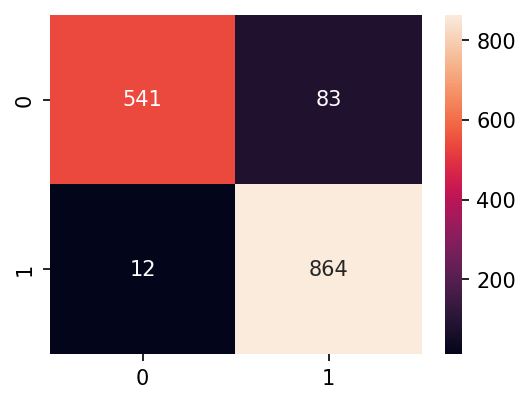

In [46]:
autoencoder_model = create_model(output_size)
# Fit data to model  
history = autoencoder_model.fit(X_train_scaled,
                    X_train_scaled,
                    epochs=100,
                    batch_size=512,
                    verbose=0)

autoencoder_predictions = get_predictions(autoencoder_model, X_test_scaled, mean_threshold)
# Show summary of performance
print(f1_score(autoencoder_predictions, y_test))
cf_matrix = confusion_matrix(y_test, autoencoder_predictions)

plt.figure(dpi=150, figsize=(4, 3))
sns.heatmap(cf_matrix, annot=True, fmt='g')
plt.show()

---

### **Reference:**

https://www.analyticsvidhya.com/blog/2021/05/anomaly-detection-using-autoencoders-a-walk-through-in-python/